In [1]:
from joblib import Memory
import glob
import pandas as pd
from biopandas.pdb import PandasPdb
import pickle

import itertools
from tqdm.notebook import tqdm

from Bio.PDB import PDBIO, Select, Polypeptide
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(52)

from protein_tools import *

In [ ]:
df = pd.read_excel('denovo_protein_database.xlsx')

pdb_ids = []

for name in df['pdbid']:
    pdb_ids.append(name.lower())

# go through the pdb files and calculate statitics about the proteins
names = []
rcos = []
types = []
lengths = []
loop_perc = []
helix_perc = []
beta_perc = []

for pdb in tqdm(glob.glob('de_novo_database/*.pdb')):
    name = pdb.split('/')[-1].replace('.pdb','')
    print(name)
    try:
        pdb_file = pdb
        rco, contact_count, target_chain_length, protein_class = calculate_relative_contact_order(pdb_file, distance_cutoff=8.0, min_seq_separation=4, verbose=False, sse_from_pdb=False, shortest=True)
        names.append(name.upper())
        rcos.append(rco)
        types.append('de novo')
        lengths.append(target_chain_length)
    except:
        print('skipping')

# go through the database and find the years of publication, method for design, fuction and number of amino acids
years = []
methods = []
functions = []
n_aas = []

for name in names:
    method = str(df[df['pdbid'] == name]['method'])

    method = method.split('   ')[1].split('\n')[0]
    
    year = int(df[df['pdbid'] == name]['year'])
    
    years.append(year)
    methods.append(method)
    
    f = str(df[df['pdbid'] == name]['functional']).split(' ')[4].split('\n')[0]
    functions.append(f)
    n_aa = str(df[df['pdbid'] == name]['n_aa']).split(' ')[4].split('\n')[0]
    n_aas.append(int(n_aa))

d = {'year': years, 'rcos':rcos, 'function': functions, 'length': n_aas, 'method': methods}

df2 = pd.DataFrame.from_dict(d)

In [ ]:
names_wt = []
rcos_wt = []
types_wt = []
lengths_wt = []

for pdb in tqdm(glob.glob('native_domain_database/*.pdb')):
    name = pdb.split('/')[-1].replace('.pdb','')
    print(name)
    pdb_file = pdb
    
    try:
        rco, contact_count, target_chain_length, protein_class = calculate_relative_contact_order(pdb_file, distance_cutoff=8.0, min_seq_separation=4, verbose=False, sse_from_pdb=False, shortest=True)
        names_wt.append(name.upper())
        rcos_wt.append(rco)
        types_wt.append('natural')
        lengths_wt.append(target_chain_length)
    except:
        print('skipping')
        continue

d = {'type': types_wt + types, 'rcos': rcos_wt + rcos, 'length': lengths_wt + lengths}

df3 = pd.DataFrame.from_dict(d)

# Figure 5a

/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

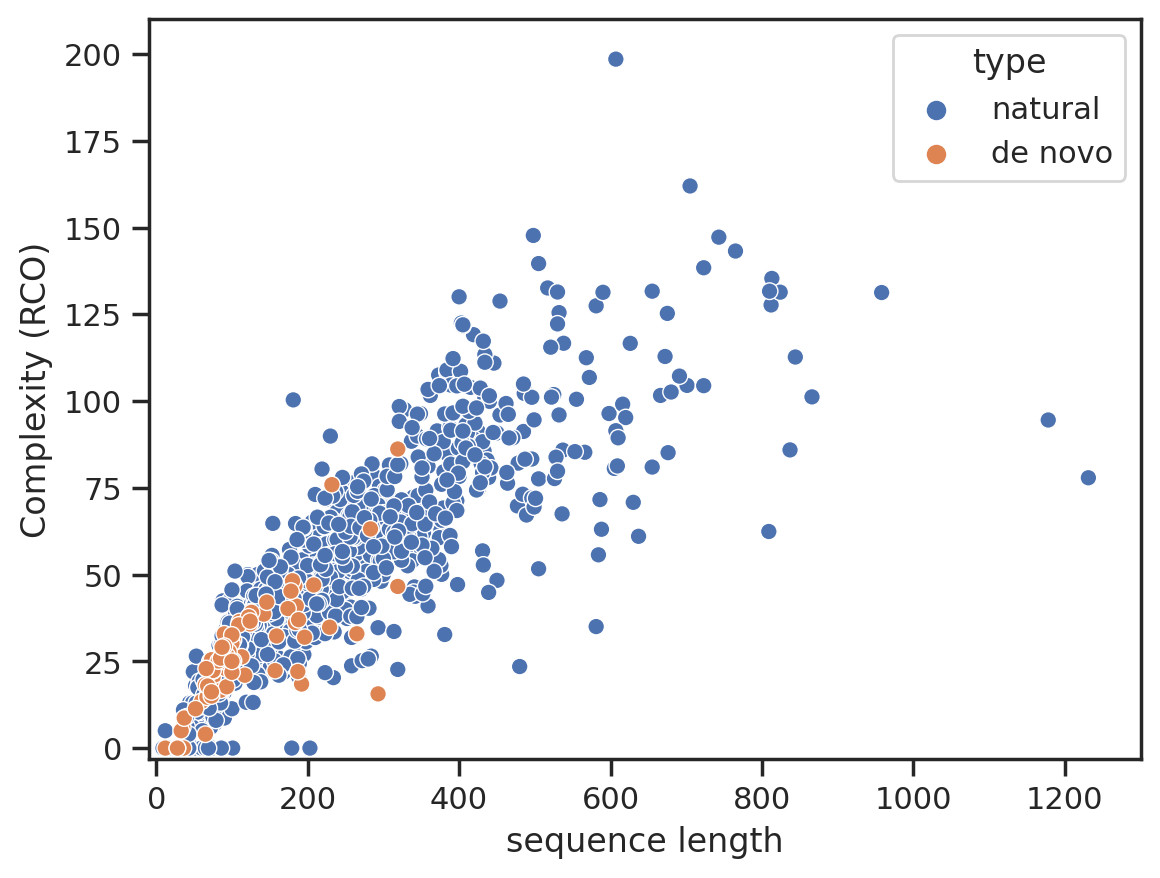

In [4]:
plt.figure(dpi=200)
sns.set_theme(style="ticks")
sns.scatterplot(data=df3, x="length", y="rcos", hue="type", linewidth=0.5)
plt.xlabel('sequence length')
plt.ylabel('Complexity (RCO)')
plt.axis([-10, 1300, -3, 210])
plt.savefig('figures/de_novo_vs_natural.svg')
plt.show()

# Figure 5b

In [ ]:
types = []
loop_perc = []
helix_perc = []
beta_perc = []

for pdb in tqdm(glob.glob('native_domain_database/*.pdb')):
    name = pdb.split('/')[-1].replace('.pdb','')
    pdb_file = pdb
    
    try:
        total_count, helix_count, sheet_count, loop_count = obtain_sse_content(pdb_file)
        types.append('natural')
        loop_perc.append((loop_count/total_count)*100)
        helix_perc.append((helix_count/total_count)*100)
        beta_perc.append((sheet_count/total_count)*100)
    except:
        continue

for pdb in tqdm(glob.glob('de_novo_database/*.pdb')):
    name = pdb.split('/')[-1].replace('.pdb','')
    pdb_file = pdb
    
    try:
        total_count, helix_count, sheet_count, loop_count = obtain_sse_content(pdb_file)
        types.append('de novo')
        loop_perc.append((loop_count/total_count)*100)
        helix_perc.append((helix_count/total_count)*100)
        beta_perc.append((sheet_count/total_count)*100)
    except:
        continue

In [8]:
d2 = {'type': [], 'content': [], 'content_perc': []}

for i in range(len(types)):
    #append loop
    d2['type'].append('loop')
    d2['content'].append(types[i])
    d2['content_perc'].append(loop_perc[i])
    
    # append helix
    d2['type'].append('helix')
    d2['content'].append(types[i])
    d2['content_perc'].append(helix_perc[i])
    
    # append sheet
    d2['type'].append('sheet')
    d2['content'].append(types[i])
    d2['content_perc'].append(beta_perc[i])
    
df4 = pd.DataFrame.from_dict(d2)

/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

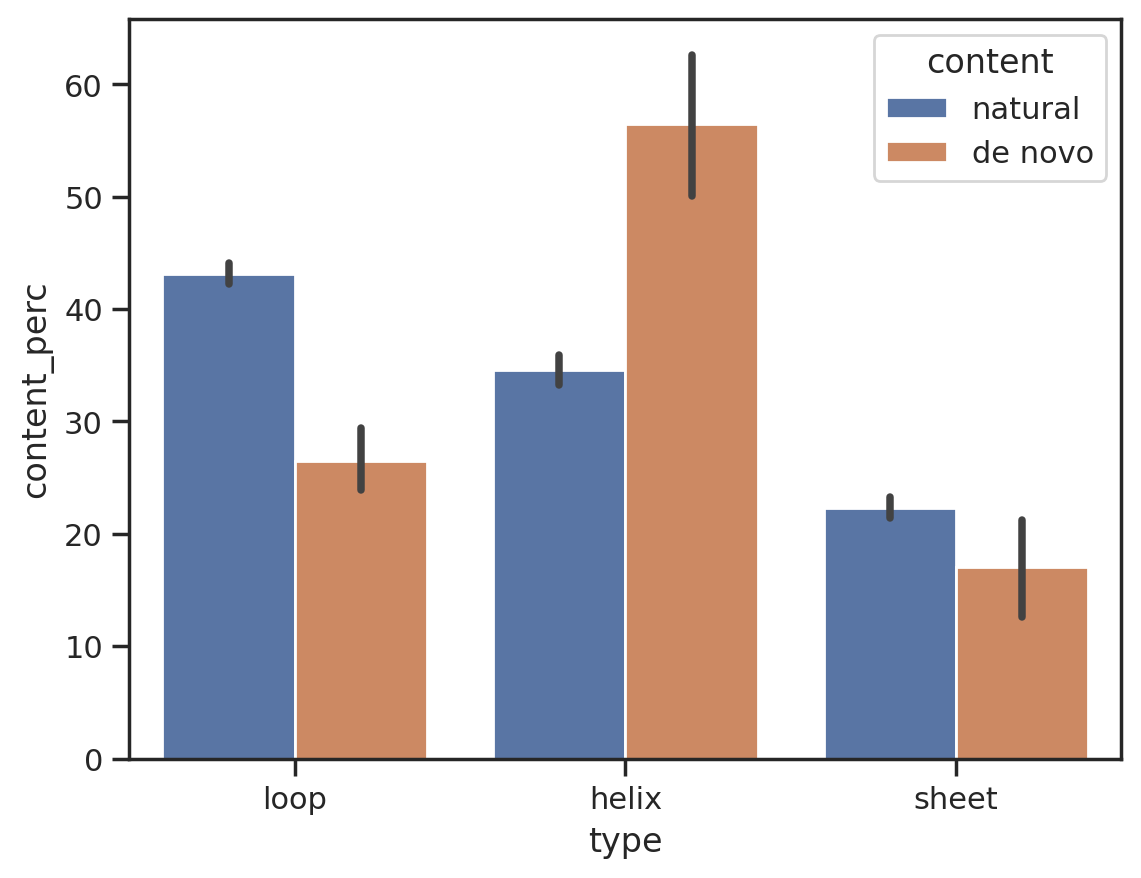

In [9]:
plt.figure(dpi=200)
sns.set_theme(style="ticks")
sns.barplot(data=df4, x="type", y="content_perc", hue = 'content')
plt.savefig('figures/de_novo_vs_natural_content.svg')
plt.show()

# Figure 5c

/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

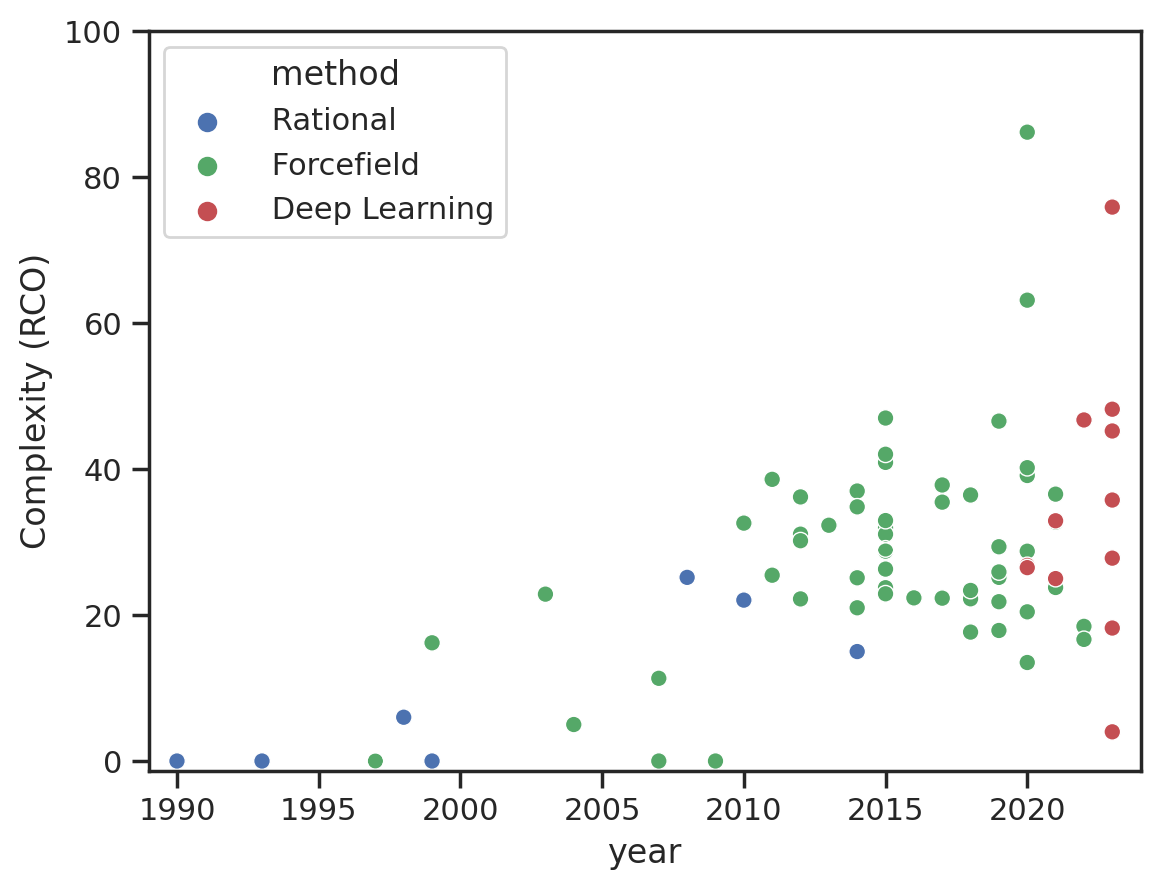

In [10]:
# Define the plot order
plot_order = [' Rational', '', ' Forcefield', ' Deep Learning']

plt.figure(dpi=200)
sns.set_theme(style="ticks")
sns.scatterplot(data=df2, x="year", y="rcos", hue="method", hue_order = plot_order, linewidth=0.5)
plt.xlabel('year')
plt.ylabel('Complexity (RCO)')
plt.axis([1989, 2024, -1.3, 100])
plt.savefig('figures/complexity_over_time.svg')
plt.show()

# Figure 5d

In [14]:
types = []
loop_perc = []
helix_perc = []
beta_perc = []
hydrophobicity = []
shape_comp = []
SA = []
packing_score = []
nres_interface = []
nhbonds = []
unsat_nhbonds = []
bb_hbonds = []

# load all stats
for file in glob.glob('native_PPI_interface_scores/*.pickle'):
    with open(file, 'rb') as f:
        x = pickle.load(f)
    
    types.append('natural_PPI_interface')
    loop_perc.append(x['loop_perc'])
    helix_perc.append(x['helix_perc'])   
    beta_perc.append(x['beta_perc'])
    hydrophobicity.append(x['interface_hydrophobicity'])
    shape_comp.append(x['interface_sc'])
    SA.append(x['interface_dSASA'])
    packing_score.append(x['interface_packstat'])
    nres_interface.append(x['interface_nres'])
    nhbonds.append(x['interface_interface_hbonds'])
    unsat_nhbonds.append(x['interface_delta_unsat_hbonds'])
    bb_hbonds.append(x['interface_bb_hbonds'])
    
# load all stats
for file in glob.glob('de_novo_PPI_interface_scores/*.pickle'):
    with open(file, 'rb') as f:
        x = pickle.load(f)
    
    types.append('de_novo_PPI_interface')
    loop_perc.append(x['loop_perc'])
    helix_perc.append(x['helix_perc'])   
    beta_perc.append(x['beta_perc'])
    hydrophobicity.append(x['interface_hydrophobicity'])
    shape_comp.append(x['interface_sc'])
    SA.append(x['interface_dSASA'])
    packing_score.append(x['interface_packstat'])
    nres_interface.append(x['interface_nres'])
    nhbonds.append(x['interface_interface_hbonds'])
    unsat_nhbonds.append(x['interface_delta_unsat_hbonds'])
    bb_hbonds.append(x['interface_bb_hbonds'])


nhbonds_per_SASA = []
nhbonds_bb_per_SASA = []
for i in range(len(nhbonds)):
    nhbonds_per_SASA.append(nhbonds[i]/(SA[i]+0.001))
    nhbonds_bb_per_SASA.append(bb_hbonds[i]/(SA[i]+0.001))

In [15]:
d2 = {'type': [], 'content': [], 'content_perc': []}

for i in range(len(types)):
    #append loop
    d2['type'].append('loop')
    d2['content'].append(types[i])
    d2['content_perc'].append(loop_perc[i])
    
    # append helix
    d2['type'].append('helix')
    d2['content'].append(types[i])
    d2['content_perc'].append(helix_perc[i])
    
    # append sheet
    d2['type'].append('sheet')
    d2['content'].append(types[i])
    d2['content_perc'].append(beta_perc[i])
    
df5 = pd.DataFrame.from_dict(d2)

d3 = {'type': types, 'interface_hydrophobicity': hydrophobicity, 'interface_shape_complementarity': shape_comp, 'interface_surface_area': SA, 'interface_packing_score': packing_score,
     'nres_interface': nres_interface, 'nhbonds': nhbonds, 'i_unsat_nhbonds': unsat_nhbonds, 'i_bb_hbonds': bb_hbonds, 'nhbonds_per_SASA': nhbonds_per_SASA, 'nhbonds_bb_per_SASA': nhbonds_bb_per_SASA}
df6 = pd.DataFrame.from_dict(d3)

# Figure 5d

/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

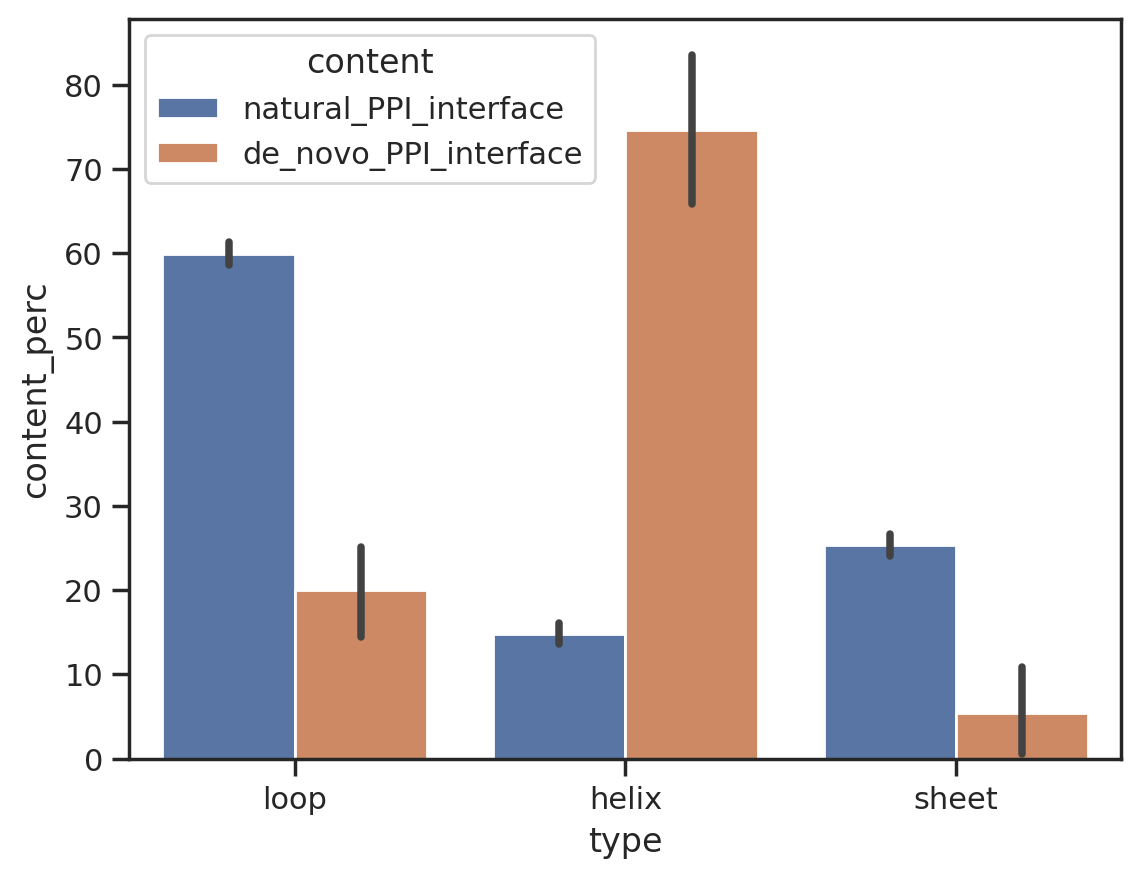

In [16]:
plt.figure(dpi=200)
sns.set_theme(style="ticks")
sns.barplot(data=df5, x="type", y="content_perc", hue = 'content')
plt.savefig('figures/de_novo_vs_natural_PPI.svg')
plt.show()

# Figure 5e

/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


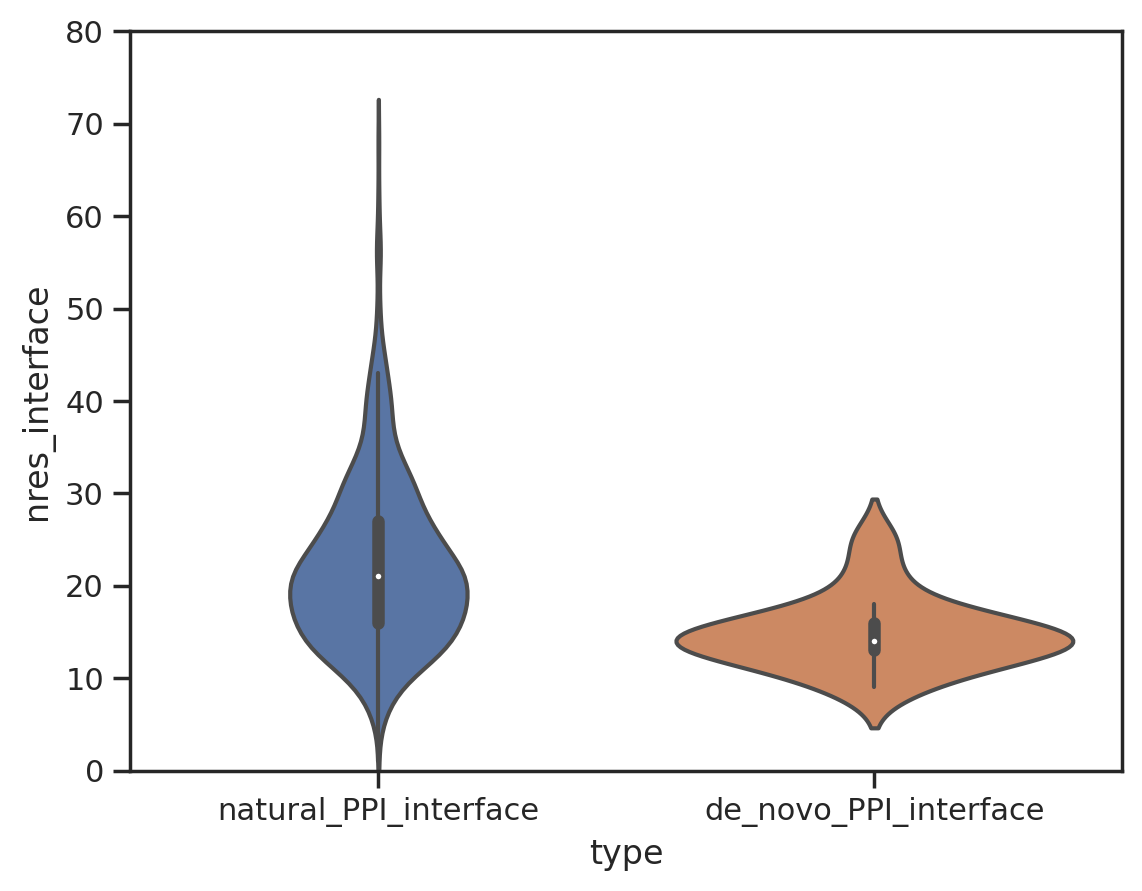

In [19]:
plt.figure(dpi=200)
sns.set_theme(style="ticks")
# ax = sns.barplot(data=df6, x="type", y="nres_interface")

# Adjust the width of the bars
ax = sns.violinplot(x='type', y='nres_interface', data=df6, height=8)

plt.ylim(0,80)
plt.savefig('figures/de_novo_vs_natural_nres.svg')
plt.show()

# Figure 5f

/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/goverde/miniconda3/envs/ColabDesign/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


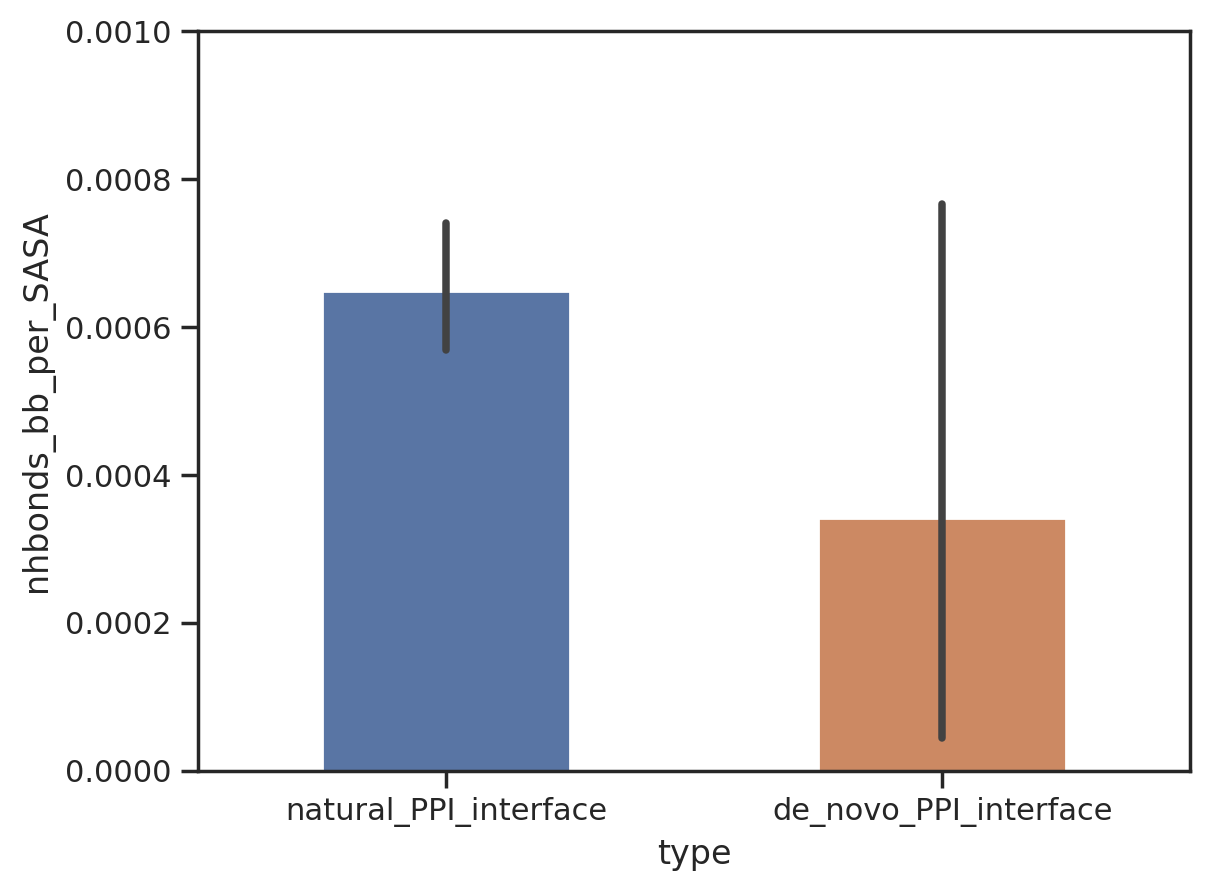

In [20]:
# unsathbonds
plt.figure(dpi=200)
sns.set_theme(style="ticks")
ax = sns.barplot(data=df6, x="type", y="nhbonds_bb_per_SASA")

# Adjust the width of the bars
bar_width = 0.5  # Set this to desired width. 1.0 is default.
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    center = x + width / 2.
    bar.set_x(center - bar_width/2.)
    bar.set_width(bar_width)

plt.ylim(0, 0.001)
plt.savefig('figures/de_novo_vs_natural_nhbonds_bb_per_SASA.svg')
plt.show()